# validation test for scalar diffusion with a constant source term
### this validation test follows "H K Versteeg and W Malalasekera, An Introduction to Computational Fluid Dynamics: THE FINITE VOLUME METHOD, Second Edition, 2007" examples 4.1,4.2

The temperature along a metal rod is given by this equation:

Why has this markdown stopped working???

$T(x) = \left( \frac{T(L) - T(0)}{L} + \frac{S}{2k} (L-x) \right) x$

[autoreload of Fields failed: Traceback (most recent call last):
  File "/home/fynne/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/fynne/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/fynne/odin/pythonPlayground/Fields.py", line 288, in <module>
    class varScalarField(scalarField):
NameError: name 'scalarField' is not defined
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


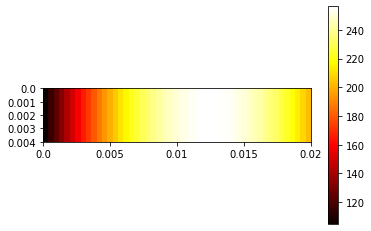

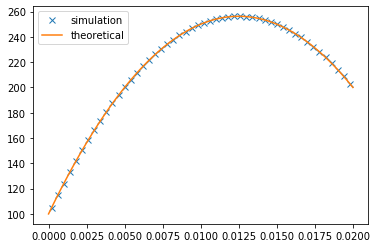

[105.   114.68 124.04 133.08 141.8  150.2  158.28 166.04 173.48 180.6
 187.4  193.88 200.04 205.88 211.4  216.6  221.48 226.04 230.28 234.2
 237.8  241.08 244.04 246.68 249.   251.   252.68 254.04 255.08 255.8
 256.2  256.28 256.04 255.48 254.6  253.4  251.88 250.04 247.88 245.4
 242.6  239.48 236.04 232.28 228.2  223.8  219.08 214.04 208.68 203.  ]


In [57]:
%reset -f
%load_ext autoreload
%autoreload 2
import Odin as backend

# write '4.1' or '4.2'
exampleId = '4.2'

# geometric parameters
LenX = {'4.1':0.5, '4.2':0.02}[exampleId]
LenY = {'4.1':0.1, '4.2':0.004}[exampleId]

# thermal conductivity [ W / (m K) ]
k = {'4.1':1000.0, '4.2':0.5}[exampleId]

# heat source [ W / m^3 ]
heatSource = {'4.1':0, '4.2':1e6}[exampleId]

# const temperature at left/right boundaries [K]
T_l = {'4.1':100, '4.2':100}[exampleId]
T_r = {'4.1':500, '4.2':200}[exampleId]

resolution = {'4.1':10, '4.2':2500}[exampleId]

# the cross sectional area is hard coded in createMatrixCoefficients()
# the cross sectional area should be defined by the geometry/mesh

geom = backend.createGeometry( 'rectangle', [LenX, LenY] )
mesh = backend.createMesh( geom, res=resolution )

# example: incompressible flow but with temp-dep density, i.e. BoussinesqFlow
# mulitphase stokes flow
# only defining types here, not instantiating objects
flowModels = [
    backend.FlowModels.ScalarConvectionDiffusion
]

sim = backend.Simulation(flowModels, mesh, geom )
#print(type(sim1._variableFields['U']).__name__) # i can use this to remove the member variable _type

myFields = sim.getFieldRegistry()
T = myFields['T']
T.setBoundaryCondition('top', 'zeroGradient')
T.setBoundaryCondition('bottom', 'zeroGradient')
T.setBoundaryCondition('left', T_l)
T.setBoundaryCondition('right', T_r)

# setting conductivity and heat source:
# should the diff coefficient not rather be a flowFlied member?
myFields['D'] = k
sim._flowmodels[0]._sourceField._raw[:,:] = heatSource

sim.solveField('T')

# post-processing:
import numpy as np
import matplotlib.pyplot as plt

# the temperature along the x-axis should develop as:
def tempDistr( x ):
    return ((T_r-T_l)/LenX + S/(2*k)*(LenX-x))*x + T_l

sim.display(T, mesh)

nbcellsX = sim._mesh._cells_x
cellSpacing = sim._mesh._uniformSpacing
L = geom._lenX

xSim = np.linspace(0+0.5*cellSpacing,LenX-0.5*cellSpacing,nbcellsX)
ySim = T._raw[0,:]

xTheo = np.linspace(0,LenX, 100)
S = np.ones(len(xTheo))*heatSource
yTheo = tempDistr(xTheo)

ax = plt.gca()
ax.plot(xSim, ySim, 'x', label='simulation')
ax.plot(xTheo, yTheo, label='theoretical')

plt.legend()
plt.show()

print(ySim)